In [7]:
# # Load the Drive helper and mount
from google.colab import drive

# # This will prompt for authorization.
drive.mount('/content/drive')

!ls "/content/drive/My Drive"
# https://colab.research.google.com/notebooks/io.ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Assignment5_p2_data.zip
 Classroom
'Colab Notebooks'
'Ethereum-based-review-system-master (1).zip'
 Ethereum-based-review-system-master.zip
 Ethereum-based-review-system.zip
'Getting started.pdf'
 image_6999b80e-4921-4695-9f89-e79b402eeb6320190507_135746.jpg
'Inmatelinks Tasks.gsheet'
'Notes abc.m4a'
 X_train_pad.csv
 y_train.csv


In [0]:
main_dir = "/content/drive/My Drive/A5_P2_data/"

# New Section

In [2]:
import shutil
source = "/content/drive/My Drive/Assignment5_p2_data.zip"
shutil.copy(source, "/content/")

'/content/Assignment5_p2_data.zip'

In [0]:
mkdir A5_P2_data

In [4]:
!unzip Assignment5_p2_data.zip -d /content/A5_P2_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/A5_P2_data/A_05_Part_02_Dataset/Train/normal/52f18c9e-7262-4fcc-a6bc-78e707214886.png  
  inflating: /content/A5_P2_data/A_05_Part_02_Dataset/Train/normal/52f53bb5-81fb-408b-adc7-2f8ae8932b31.png  
  inflating: /content/A5_P2_data/A_05_Part_02_Dataset/Train/normal/52fee036-272a-455a-9714-b6ff73e28403.png  
  inflating: /content/A5_P2_data/A_05_Part_02_Dataset/Train/normal/535c2337-e755-43ea-ab1d-6547a584776d.png  
  inflating: /content/A5_P2_data/A_05_Part_02_Dataset/Train/normal/536ba3bf-b867-4035-b483-35e9cbda9c0f.png  
  inflating: /content/A5_P2_data/A_05_Part_02_Dataset/Train/normal/538d24ba-8a55-4445-b0d5-f9e5812fdd49.png  
  inflating: /content/A5_P2_data/A_05_Part_02_Dataset/Train/normal/53bae9fc-3bb2-4684-b986-84bf7aa2e5a2.png  
  inflating: /content/A5_P2_data/A_05_Part_02_Dataset/Train/normal/53bed796-1a7b-406b-b37c-d37facb41158.png  
  inflating: /content/A5_P2_data/A_05_Part_02_Dataset/Train/normal/53

In [10]:
ls

A5_P2_data/  Assignment5_p2_data.zip  drive/  sample_data/


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [18]:
train_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
data_dir = "A5_P2_data/A_05_Part_02_Dataset"
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train'    ,  transform=train_transforms )
#test_data = datasets.ImageFolder(data_dir + '/Test'      ,  transform=test_transforms)
val_data = datasets.ImageFolder(data_dir + '/Validation' , transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size = 50, shuffle=True )
#testloader  = torch.utils.data.DataLoader(test_data, batch_size  = 50, shuffle = False )
valloader   = torch.utils.data.DataLoader(val_data, batch_size   =50, shuffle=True)

class_names = train_data.classes
print("Classes: ", ', '.join(class_names))

Classes:  covid-19, normal, pneumonia


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


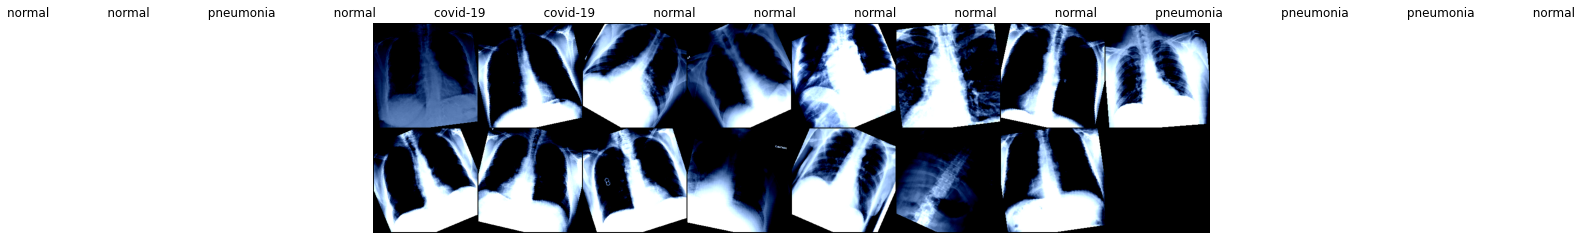

In [19]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.01)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    plt.figure(figsize=(15,8))
    imshow(out, title='               '.join([class_names[x] for x in classes]))

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs[:15], classes[:15])

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [0]:
def one_hot_encoding(c, Y):
  Y  = Y.cpu().numpy()
  y = np.zeros((Y.shape[0], len(c)))
  y[np.arange(Y.shape[0]), Y] = 1
  C_i = c.index("covid-19")
  P_i = c.index("pneumonia")
  for val in y:
    if int(val[C_i]) == 1:
      val[P_i] = 1

  return torch.tensor(y).to(device) 

In [0]:
def one_hot_decoding(c, Y):
  Y  = Y.cpu().numpy()
  C_i = c.index("covid-19")
  P_i = c.index("pneumonia")
  N_i = c.index("normal")
 
  output = []
  for val in Y:
    
    if (int(val[C_i]) == 1) :
      output.append(C_i)
    elif(int(val[P_i]) == 1):
      output.append(P_i)
    elif(int(val[N_i]) == 1):
      output.append(N_i)
    else:
      output.append(np.random.randint(3))

  return torch.tensor(output).to(device)

In [0]:
def FocalLoss(y_pred, Y , get_ipython = 2 , a = 0.24) : 
    pt = torch.exp(-torch.nn.functional.binary_cross_entropy_with_logits(y_pred , one_hot_encoding(class_names,Y) , reduction='none'))
    return - torch.mean((a*(1-pt)**(g))*torch.log(pt))

In [0]:
def predtionFunc(y ):
  with torch.no_grad():  
    sig_layer = nn.Sigmoid()
    sig_out = sig_layer(y)
    pred    = sig_layer(y)

    sig_out[sig_out>0.5] =1
    sig_out[sig_out<0.5] = 0
    #print(sig_out)
    predicted =  one_hot_decoding(class_names, sig_out)
    p = torch.sum(sig_out, dim=1)
    n = list(p.cpu().numpy())
    if 0 in n :
      ind = n.index(0)
      _,l =  torch.max(pred[ind] , 0)
      sig_out[ind][l] = 1
      predicted[ind] = l
    
    #del sig_out,pred ,p 

    return predicted ,sig_out

In [0]:
def TrainModel(model ,trainingDataLoader,ValidationDataLoader , datapath , Loss = None , Epochs = 10, lr = 0.001, momentum= 0.9  ):

  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

  model.to(device)
  model.train()


  LogData = {}
  LogData['Epochs'] = []
  LogData["Loss"] = {'train' : [] , 'val': []}
  LogData["Accuracy"] = {'train' : [] , 'val': []}

  for epoch in range(Epochs):  # loop over the dataset multiple times
      print("*********************** Epoch ",epoch, " ***************************************")
      #********************************* Train Data**********************************************
      running_loss = 0.0
      batches_number = 0
      correct = 0
      total = 0
      correct1 = 0
      pbar = tqdm(enumerate(trainingDataLoader), position=0, leave=True)
      for i, data in pbar:

          # get the inputs
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          encoded_labels = one_hot_encoding(class_names, labels)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs) 
          if(Loss == 'FocalLoss'):
            loss = FocalLoss(outputs, labels)
          else:
            loss = criterion(outputs ,encoded_labels )

          loss.backward()                       #----> backward pass
          optimizer.step()                      #----> weights update

          # print statistics
          running_loss += loss.item()
          pbar.set_description(
              'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, i * len(inputs), len(trainingDataLoader.dataset),
                  100. * i / len(trainingDataLoader),
                  loss.data.item()))

          
          predicted ,_ =  predtionFunc(outputs.data )
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          
          batches_number = i

      LogData["Loss"]["train"].append(np.round((running_loss/(batches_number+1)),decimals=4))
      LogData["Accuracy"]["train"].append(np.round((100 * correct / total),decimals=4))
      
      #********************************* Validation Data**********************************************
      running_loss = 0.0
      batches_number = 0
      correct = 0
      total = 0

      for i, data in enumerate(ValidationDataLoader):
          # get the inputs
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          encoded_labels = one_hot_encoding(class_names, labels)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)  
                      #----> forward pass
          if(Loss == 'FocalLoss'):              #----> forward pass
            loss = FocalLoss(outputs, labels)
          else:
            
            loss = criterion(outputs ,encoded_labels )
          
          running_loss += loss.item()
          batches_number = i

          #accuracy
          predicted,_  = predtionFunc(outputs.data)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      LogData["Epochs"].append(epoch)
      LogData["Loss"]["val"].append(np.round((running_loss/(batches_number+1)),decimals=4))
      LogData["Accuracy"]["val"].append(np.round((100 * correct / total),decimals=4))
      
      print("*******************************************************************************")
      print("Loss: \n Train Data:"      ,LogData["Loss"]["train"][epoch], "\t Validation Data:" , LogData["Loss"]["val"][epoch] )
      print("Accuracy: \n Train Data:"      ,LogData["Accuracy"]["train"][epoch], "\t Validation Data:" , LogData["Accuracy"]["val"][epoch] )

      #Saving Model and LogData   
      #torch.save(model.state_dict(), main_dir+datapath+'.pth')
      torch.save(model, main_dir+datapath+'.pth')
      
      f = open(main_dir+datapath+'_log.txt' ,mode='w')
      f.write(str(LogData))
      f.close()

  plt.figure(figsize=(15,4))
  plt.subplot(1,2,1)
  plt.gca().set(title='Loss Curve over epochs', ylabel='Loss', xlabel='epochs')            
  plt.plot(LogData['Epochs'],LogData["Loss"]["train"] , label="Train")
  plt.plot(LogData['Epochs'],LogData["Loss"]["val"] , label="Validation")
  plt.legend()

  plt.subplot(1,2,2) 
  plt.gca().set(title='Accuracy Curve over epochs', ylabel='Accuracy', xlabel='epochs')            
  plt.plot(LogData['Epochs'],LogData["Accuracy"]['train'] , label="Train")
  plt.plot(LogData['Epochs'],LogData["Accuracy"]['val'] , label="Validation")
  plt.legend()

  plt.savefig(main_dir+datapath+ "_plot.png")

In [0]:
def printConfusion_Matrix(c , classes_info , title):
  plt.pause(0.01)
  plt.figure()
  ax= plt.subplot()
  sns.heatmap(c, annot=True, ax = ax  ,cmap='Greens' ,fmt='g');

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title(title); 
  ax.xaxis.set_ticklabels(classes_info); ax.yaxis.set_ticklabels(classes_info);



In [0]:
def modelEvaluate(model, DataLoader):

  #  if torch.cuda.is_available():
  #      model.cuda()

  correct = 0
  total = 0
  predlist=torch.zeros(0,dtype=torch.long, device='cpu')
  labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

  e_predlist = []  #=torch.zeros(0,dtype=torch.long, device='cpu')
  e_labelslist =  []#  =torch.zeros(0,dtype=torch.long, device='cpu')
  acc = 0
  fscore = 0

  with torch.no_grad():
      pbar = tqdm(enumerate(DataLoader), position=0, leave=True)
      batches = 0
      for i , data in pbar:

        images, labels = data
        images, labels = images.to(device), labels.to(device)
        encoded_labels = one_hot_encoding(class_names, labels)
        
        outputs = model(images)

        predicted  , e_predicted = predtionFunc(outputs.data )
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        labelslist=torch.cat([labelslist,labels.view(-1).cpu()])
        #print(e_predicted)
        for item in e_predicted.cpu().numpy():
            e_predlist.append(item)

        for item in encoded_labels.cpu().numpy():
            e_labelslist.append(item)

  
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pbar.set_description(
              'Data Passed:  [{}/{} ({:.0f}%)]'.format(
                  i * len(inputs), len(DataLoader.dataset),
                  100. * i / len(DataLoader)
                  ))

  #conf_mat = confusion_matrix(labelslist.numpy(), predlist.numpy()) 
  e_labelslist = np.array(e_labelslist) 
  e_predlist = np.array(e_predlist) 

  conf_mat_multilabel = multilabel_confusion_matrix(e_labelslist, e_predlist) 
  printConfusion_Matrix(conf_mat_multilabel[class_names.index("covid-19")] , ['-ive','+ive'] , '0-index Label (Covid -19)' )
  printConfusion_Matrix(conf_mat_multilabel[class_names.index("normal")] , ['-ive','+ive'] ,    '1-index Label (Normal)')
  printConfusion_Matrix(conf_mat_multilabel[class_names.index("pneumonia")] , ['-ive','+ive']  , '2-index Label (Pneumonia)')
  plt.pause(0.1) 
  print(classification_report(e_labelslist, e_predlist, target_names=class_names))

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True) 

In [0]:
vgg16_NL = models.vgg16(pretrained=True)
# Freeze training for all layers of Model
for param in vgg16_NL.features.parameters():
    param.require_grad = False

rollnumber_neurons = (16 * 10 )  + 100
num_features = vgg16_NL.classifier[0].in_features

newClassifierLayers = [nn.Linear(num_features, rollnumber_neurons) , nn.ReLU(inplace=True) , nn.Dropout(p =0.5)  ]
newClassifierLayers.extend([nn.Linear(rollnumber_neurons, len(class_names))])
vgg16_NL.classifier = nn.Sequential(*newClassifierLayers)
#vgg16_NL = torch.load(main_dir+'vgg16.pth')


Data Passed:  [600/628 (92%)]: : 13it [05:31, 25.49s/it]


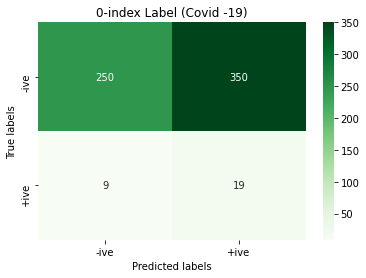

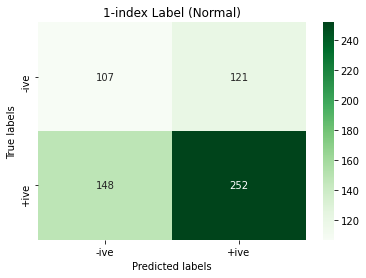

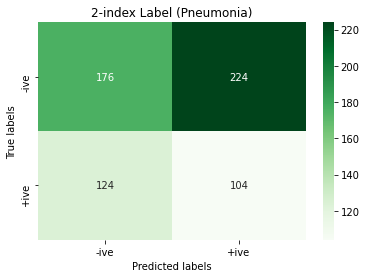

              precision    recall  f1-score   support

    covid-19       0.05      0.68      0.10        28
      normal       0.68      0.63      0.65       400
   pneumonia       0.32      0.46      0.37       228

   micro avg       0.35      0.57      0.43       656
   macro avg       0.35      0.59      0.37       656
weighted avg       0.52      0.57      0.53       656
 samples avg       0.32      0.57      0.40       656



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
modelEvaluate(vgg16_NL , valloader)


In [34]:
trainedmodel = TrainModel(vgg16 , trainloader , valloader ,'vgg16_focal_loss',FocalLoss, 10 , 0.0001,  0.9 )

0it [00:00, ?it/s]

*********************** Epoch  0  ***************************************


ValueError: ignored

In [8]:
trainedmodel

NameError: ignored